In [1]:
from UTILITY_quickstart import *
import json

importedDefaultSettings = loadConfig("setLattice_configs/2024-10-14_twoBunch_baseline.yml")
    # "2024-10-14_twoBunch_baseline.yml" already has
    #     centerBC14 : False
    #     centerBC20 : False
    #     centerMFFF : False
    #     assertBC14Energy : False
    #     assertBC20Energy : False

#Ad hoc attempt to get real median energies (with wakes and CSR) to 4.5 and 10.0 GeV respectively
#importedDefaultSettings = importedDefaultSettings | { "L2EnergyOffset" : 80.0e6, "L2EnergyOffset" : 130.0e6 } 

In [2]:
csrTF = True

tao = initializeTao(
    inputBeamFilePathSuffix = importedDefaultSettings["inputBeamFilePathSuffix"],
    
    csrTF = csrTF,
    numMacroParticles=1e5,
    scratchPath = "/tmp",
    randomizeFileNames = True
)

setLattice(tao, **importedDefaultSettings)


L1MatchStrings, L2MatchStrings, L3MatchStrings, selectMarkers = getLinacMatchStrings(tao)
L0BMatchStrings = ["L0BF"]

Environment set to:  /Users/nmajik/Documents/SLAC/FACET2-Bmad-PyTao
Tracking to end
CSR on
Overwriting lattice with setLattice() defaults
No defaults file provided to setLattice(). Using setLattice_configs/defaults.yml
Number of macro particles = 100000.0
Beam created, written to /tmp/beams/activeBeamFile_10598523806183081139.h5, and reinit to tao


In [3]:
#PyTao monkey patch, from ChatGPT https://chatgpt.com/c/6842031d-dd38-800b-a4f1-5c98f857ffc0

import types

def safe_get_output(self, reset=True):
    n_lines = self.so_lib.tao_c_out_io_buffer_num_lines()
    lines = []
    for i in range(1, n_lines + 1):
        raw = self.so_lib.tao_c_out_io_buffer_get_line(i)
        try:
            lines.append(raw.decode('utf-8'))
        except UnicodeDecodeError:
            lines.append("[Error decoding output line]")
    if reset:
        self.so_lib.tao_c_out_io_buffer_reset()
    return lines

tao.get_output = types.MethodType(safe_get_output, tao)


In [4]:
def jitterLinac(
    L0BPhaseErrorDeg = 0.1,
    L1PhaseErrorDeg  = 0.7,
    L2PhaseErrorDeg  = 0.4,
    L3PhaseErrorDeg  = 0.4,

    L0BGradientErrorPercent = 0.5, 
    L1GradientErrorPercent  = 0.25,
    L2GradientErrorPercent  = 0.3,
    L3GradientErrorPercent  = 0.3,
):
    #Hardcoded numbers from https://docs.google.com/spreadsheets/d/1xeCUImz5uFSq6QA3wV91dG38s-8cyVXQMGw9hjPKa6M/edit?gid=0#gid=0


    ######################################################
    #Apply same errors to all elements in the linac region
    ######################################################
    
    #Convert to "turns"
    L0BPhaseError = np.random.normal() * L0BPhaseErrorDeg / 360.0 
    L1PhaseError  = np.random.normal() * L1PhaseErrorDeg  / 360.0 
    L2PhaseError  = np.random.normal() * L2PhaseErrorDeg  / 360.0 
    L3PhaseError  = np.random.normal() * L3PhaseErrorDeg  / 360.0

    #Give as multiplier to base gradient
    L0BGradientErrorRelative = np.random.normal() * L0BGradientErrorPercent / 100.0
    L1GradientErrorRelative  = np.random.normal() * L1GradientErrorPercent  / 100.0
    L2GradientErrorRelative  = np.random.normal() * L2GradientErrorPercent  / 100.0
    L3GradientErrorRelative  = np.random.normal() * L3GradientErrorPercent  / 100.0
    
    #Prevent recalculation until changes are made
    tao.cmd("set global lattice_calc_on = F")    
    
    [ tao.cmd(f"set ele {ele} PHI0_ERR = {L0BPhaseError}") for ele in L0BMatchStrings ]
    [ tao.cmd(f"set ele {ele} PHI0_ERR = {L1PhaseError}")  for ele in L1MatchStrings  ]
    [ tao.cmd(f"set ele {ele} PHI0_ERR = {L2PhaseError}")  for ele in L2MatchStrings  ]
    [ tao.cmd(f"set ele {ele} PHI0_ERR = {L3PhaseError}")  for ele in L3MatchStrings  ]
    
    for ele in L0BMatchStrings:
        baseGradient = tao.ele_gen_attribs(ele)["GRADIENT"]
        specificGradientError = L0BGradientErrorRelative * baseGradient
        tao.cmd(f"set ele {ele} GRADIENT_ERR = {specificGradientError}")

    for ele in L1MatchStrings:
        baseGradient = tao.ele_gen_attribs(ele)["GRADIENT"]
        specificGradientError = L1GradientErrorRelative * baseGradient
        tao.cmd(f"set ele {ele} GRADIENT_ERR = {specificGradientError}")

    for ele in L2MatchStrings:
        baseGradient = tao.ele_gen_attribs(ele)["GRADIENT"]
        specificGradientError = L2GradientErrorRelative * baseGradient
        tao.cmd(f"set ele {ele} GRADIENT_ERR = {specificGradientError}")

    for ele in L3MatchStrings:
        baseGradient = tao.ele_gen_attribs(ele)["GRADIENT"]
        specificGradientError = L3GradientErrorRelative * baseGradient
        tao.cmd(f"set ele {ele} GRADIENT_ERR = {specificGradientError}")
    
    #Reenable lattice calculations
    tao.cmd("set global lattice_calc_on = T")

    return {
    "L0BPhaseError" : L0BPhaseError,
    "L1PhaseError"  : L1PhaseError,
    "L2PhaseError"  : L2PhaseError,
    "L3PhaseError"  : L3PhaseError,

    "L0BGradientErrorRelative" : L0BGradientErrorRelative,
    "L1GradientErrorRelative"  : L1GradientErrorRelative,
    "L2GradientErrorRelative"  : L2GradientErrorRelative,
    "L3GradientErrorRelative"  : L3GradientErrorRelative
    }



    ######################################################    
    #Each element gets independent, random error
    ######################################################
    
    # matchStringsDict = {
    #     "L0B" : L0BMatchStrings,
    #     "L1"  : L1MatchStrings,
    #     "L2"  : L2MatchStrings,
    #     "L3"  : L3MatchStrings
    # }

    # #Convert to "turns"
    # phaseErrorScaleDict = {
    #     "L0B" : L0BPhaseErrorDeg / 360.0,
    #     "L1"  : L1PhaseErrorDeg  / 360.0,
    #     "L2"  : L2PhaseErrorDeg  / 360.0,
    #     "L3"  : L3PhaseErrorDeg  / 360.0
    # }

    # #Give as multiplier to base gradient
    # gradientErrorScaleDict = {
    #     "L0B" : L0BGradientErrorPercent / 100.0,
    #     "L1"  : L1GradientErrorPercent  / 100.0,
    #     "L2"  : L2GradientErrorPercent  / 100.0,
    #     "L3"  : L3GradientErrorPercent  / 100.0
    # }
        

    # exportDict = {
    #     "L0BPhaseError" : phaseErrorScaleDict["L0B"],
    #     "L1PhaseError"  : phaseErrorScaleDict["L1"],
    #     "L2PhaseError"  : phaseErrorScaleDict["L2"],
    #     "L3PhaseError"  : phaseErrorScaleDict["L3"],
    
    #     "L0BGradientErrorRelative" : gradientErrorScaleDict["L0B"],
    #     "L1GradientErrorRelative"  : gradientErrorScaleDict["L1"],
    #     "L2GradientErrorRelative"  : gradientErrorScaleDict["L2"],
    #     "L3GradientErrorRelative"  : gradientErrorScaleDict["L3"]
    # }
    
    # for linacChunkName in ["L0B", "L1", "L2", "L3"]:
    
    #     for ele in matchStringsDict[linacChunkName]:

    #         specificPhaseError = np.random.normal() * phaseErrorScaleDict[linacChunkName]
    #         tao.cmd(f"set ele {ele} PHI0_ERR = {specificPhaseError}")

    #         exportDict = exportDict | { ele+"_PHI0_ERR" : specificPhaseError }
            

    #         baseGradient = tao.ele_gen_attribs(ele)["GRADIENT"]
    #         specificGradientError = baseGradient * (np.random.normal() * gradientErrorScaleDict[linacChunkName])
            
    #         tao.cmd(f"set ele {ele} GRADIENT_ERR = {specificGradientError}")

    #         exportDict = exportDict | { ele+"_GRADIENT_ERR" : specificGradientError }

    
    # return exportDict
    



def hashDict(d):
    return str(abs(hash(json.dumps(d, sort_keys=True))))

In [5]:
trackBeam(tao, **importedDefaultSettings)

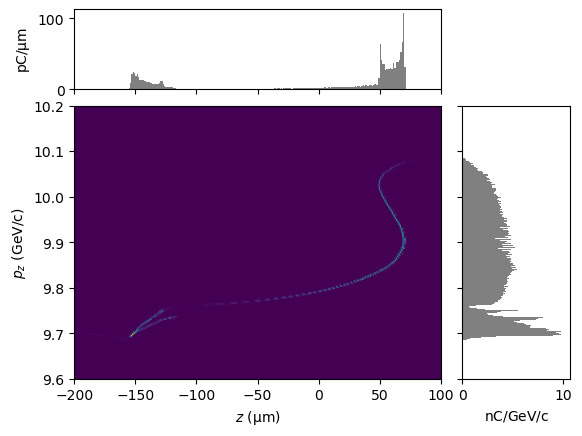

<Figure size 640x480 with 0 Axes>

In [6]:
P = getBeamAtElement(tao, "PENT")

display(plotMod(P, 'z', 'pz', bins=300, xlim = (-200e-6, 100e-6), ylim = (9.6e9, 10.2e9)))

plt.clf()

In [7]:
print( 1e-6 * tao.ele_orbit("BEGBC14_1")["p0c"] )
print( 1e-6 * np.median((getBeamAtElement(tao, "BEGBC14_1")).energy) )

print()

print( 1e-6 * tao.ele_orbit("BEGBC20")["p0c"] )
print( 1e-6 * np.median((getBeamAtElement(tao, "BEGBC20")).energy) )

print()

print( 1e-6 * tao.ele_orbit("PENT")["p0c"] )
print( 1e-6 * np.median((getBeamAtElement(tao, "PENT")).energy) )

#At nominal settings
#CSR off
# BC14 lattice / beam : 4487 / 4428 MeV
# BC20 lattice / beam : 9999 / 9860 MeV
#CSR on 
# BC14 lattice / beam : 4487 / 4430 MeV
# BC20 lattice / beam : 9999 / 9859 MeV
# PENT lattice / beam : 9999 / 9854 MeV

4487.4174969448095
4429.62568881804

9999.12104012684
9859.49879758022

9999.12104012684
9854.054570094218


In [8]:
# #Now turn off magnet compensation and tweak energy
# disableAutoMagnetEnergyCompensation(tao)

# setLinacGradientAuto( tao, L2MatchStrings, (50e6) + 4.5e9 - 0.335e9 )
# setLinacGradientAuto( tao, L3MatchStrings, (100e6) + 10.0e9 - 4.5e9 )






# trackBeam(tao, **importedDefaultSettings)







# P = getBeamAtElement(tao, "PENT")

# display(plotMod(P, 'z', 'pz', bins=300, xlim = (-200e-6, 100e-6), ylim = (9.6e9, 10.2e9)))

# plt.clf()





# print( 1e-6 * tao.ele_orbit("BEGBC14_1")["p0c"] )
# print( 1e-6 * np.median((getBeamAtElement(tao, "BEGBC14_1")).energy) )

# print()

# print( 1e-6 * tao.ele_orbit("BEGBC20")["p0c"] )
# print( 1e-6 * np.median((getBeamAtElement(tao, "BEGBC20")).energy) )

In [9]:
# jitterDict = jitterLinac()
# jitterDict = jitterLinac(
#     L0BPhaseErrorDeg = 0.1,
#     L1PhaseErrorDeg  = 0.1,
#     L2PhaseErrorDeg  = 0.1,
#     L3PhaseErrorDeg  = 0.1,

#     L0BGradientErrorPercent = 0.1,
#     L1GradientErrorPercent  = 0.1,
#     L2GradientErrorPercent  = 0.1,
#     L3GradientErrorPercent  = 0.1,
# )

# jitterDict

{'L0BPhaseError': 3.930961756772401e-05, 'L1PhaseError': -0.0032127848902473, 'L2PhaseError': -0.0016595466047945812, 'L3PhaseError': -0.0006159949010569349, 'L0BGradientErrorRelative': 0.00034347287524493295, 'L1GradientErrorRelative': 0.002070799471431816, 'L2GradientErrorRelative': 0.00044772287256615166, 'L3GradientErrorRelative': -7.73946578112476e-05}
4487.4174969448095
4422.8749072193605

9999.12104012684
9850.877648405944


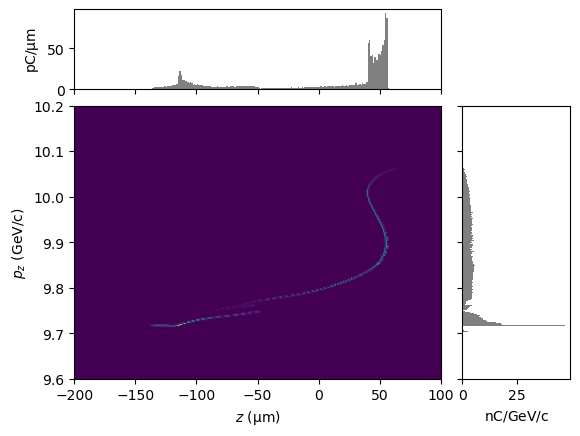

{'L0BPhaseError': 0.00019837048414252532, 'L1PhaseError': -0.002120067175017705, 'L2PhaseError': -0.000620022381304355, 'L3PhaseError': 0.0011544697481788006, 'L0BGradientErrorRelative': -0.0018543561940640696, 'L1GradientErrorRelative': -0.0009977744138286774, 'L2GradientErrorRelative': -0.0003651592585933992, 'L3GradientErrorRelative': 0.00035010809611761887}


In [ ]:
for i in range(20):
   
    try:
        #Jitter
        #jitterDict = jitterLinac()
        jitterDict = jitterLinac(
            L0BPhaseErrorDeg = 0.1,
            L1PhaseErrorDeg  = 0.7,
            L2PhaseErrorDeg  = 0.4,
            L3PhaseErrorDeg  = 0.4,
        
            L0BGradientErrorPercent = 0.5,                  #Only one klystron on L0B
            L1GradientErrorPercent  = 0.25 / np.sqrt(2),    #Two klystrons in L1
            L2GradientErrorPercent  = 0.3  / np.sqrt(25),   #Estimate 25 klystrons in L2. DNT!
            L3GradientErrorPercent  = 0.3  / np.sqrt(25),   #Estimate 25 klystrons in L3. DNT!
        )
        print(jitterDict)

        #Track
        trackBeam(tao, **importedDefaultSettings)
        P = getBeamAtElement(tao, "PENT")
        
        # trackBeam(tao, trackEnd = "BEGBC20", **importedDefaultSettings)
        # P = getBeamAtElement(tao, "BEGBC20")



        print( 1e-6 * tao.ele_orbit("BEGBC14_1")["p0c"] )
        print( 1e-6 * np.median((getBeamAtElement(tao, "BEGBC14_1")).energy) )
        
        print()
        
        print( 1e-6 * tao.ele_orbit("BEGBC20")["p0c"] )
        print( 1e-6 * np.median((getBeamAtElement(tao, "BEGBC20")).energy) )
        
        
        #display(plotMod(P, 'z', 'pz', bins=300, xlim = (-200e-6, 100e-6), ylim = (9.6e9, 10.2e9)))
        fig = plotMod(P, 'z', 'pz', bins=300, xlim = (-200e-6, 100e-6), ylim = (9.6e9, 10.2e9))

        #Export
        exportPath = "/Users/nmajik/tmpSLACData/"
        hashStr = hashDict(jitterDict)
    
        P.write(exportPath+hashStr+"_PENT.h5")
        tao.cmd("write bmad "+exportPath+hashStr+"_lat.bmad")
        
        with open(exportPath+hashStr+"_jitterDict.json", "w") as f:
            json.dump(jitterDict, f)

        fig.savefig(exportPath+hashStr+"_PENT.png")

#    except Exception as e:
#        print("An error occurred:", e)

    except:
        print("Failed!")

In [ ]:
# exportPath = "/Users/nmajik/tmpSLACData/"
# hashStr = hashDict(jitterDict)

# P.write(exportPath+hashStr+"_PENT.h5")
# tao.cmd("write bmad "+exportPath+hashStr+"_lat.bmad")

# with open(exportPath+hashStr+"_jitterDict.json", "w") as f:
#     json.dump(jitterDict, f)